## Домашняя работа №4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO.
Библиотеки: [Python, Tensorflow].

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io

import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
if 1:
    
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && unzip -q train2017.zip

--2020-07-29 18:14:45--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.137.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.137.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  14.1MB/s    in 21m 56s 

2020-07-29 18:41:33 (14.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [5]:
if 1:
   
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2020-07-29 18:50:23--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.78.140
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.78.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  14.2MB/s    in 57s     

2020-07-29 18:52:22 (13.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-07-29 18:52:25--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.228.104
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.228.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  14.1MB/s    in 19s     

2020

In [6]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [7]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0]
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))

        else: # Central crop
            shape = tf.shape(img)
            h0 = (shape[0] - inp_size) // 2
            w0 = (shape[1] - inp_size) // 2
            img = img[h0: h0 + inp_size, w0: w0 + inp_size, :]

        return img


    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)

            return img, mask_class


        dataset = tf.data.Dataset.from_tensor_slices(self.img_list[:5000])
        dataset = dataset.shuffle(buffer_size=len(self.img_list[:5000]))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset


    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,: 3], tf.float32 ) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            
            return img, mask_class

        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [8]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)


    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        
        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)
        
        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)
            
        return img_combined

In [9]:
COCO_dataset_train = COCO_Dataset('train')

loading annotations into memory...
Done (t=13.97s)
creating index...
index created!


In [10]:
COCO_dataset_test = COCO_Dataset('val')

loading annotations into memory...
Done (t=1.95s)
creating index...
index created!


In [11]:
type(COCO_dataset_train), type(COCO_dataset_test)

(__main__.COCO_Dataset, __main__.COCO_Dataset)

In [12]:
INP_SIZE = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [13]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
test_ds = COCO_dataset_test.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)

In [14]:
type(train_ds), type(test_ds)

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 tensorflow.python.data.ops.dataset_ops.BatchDataset)

In [15]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

In [16]:
model = build_model()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

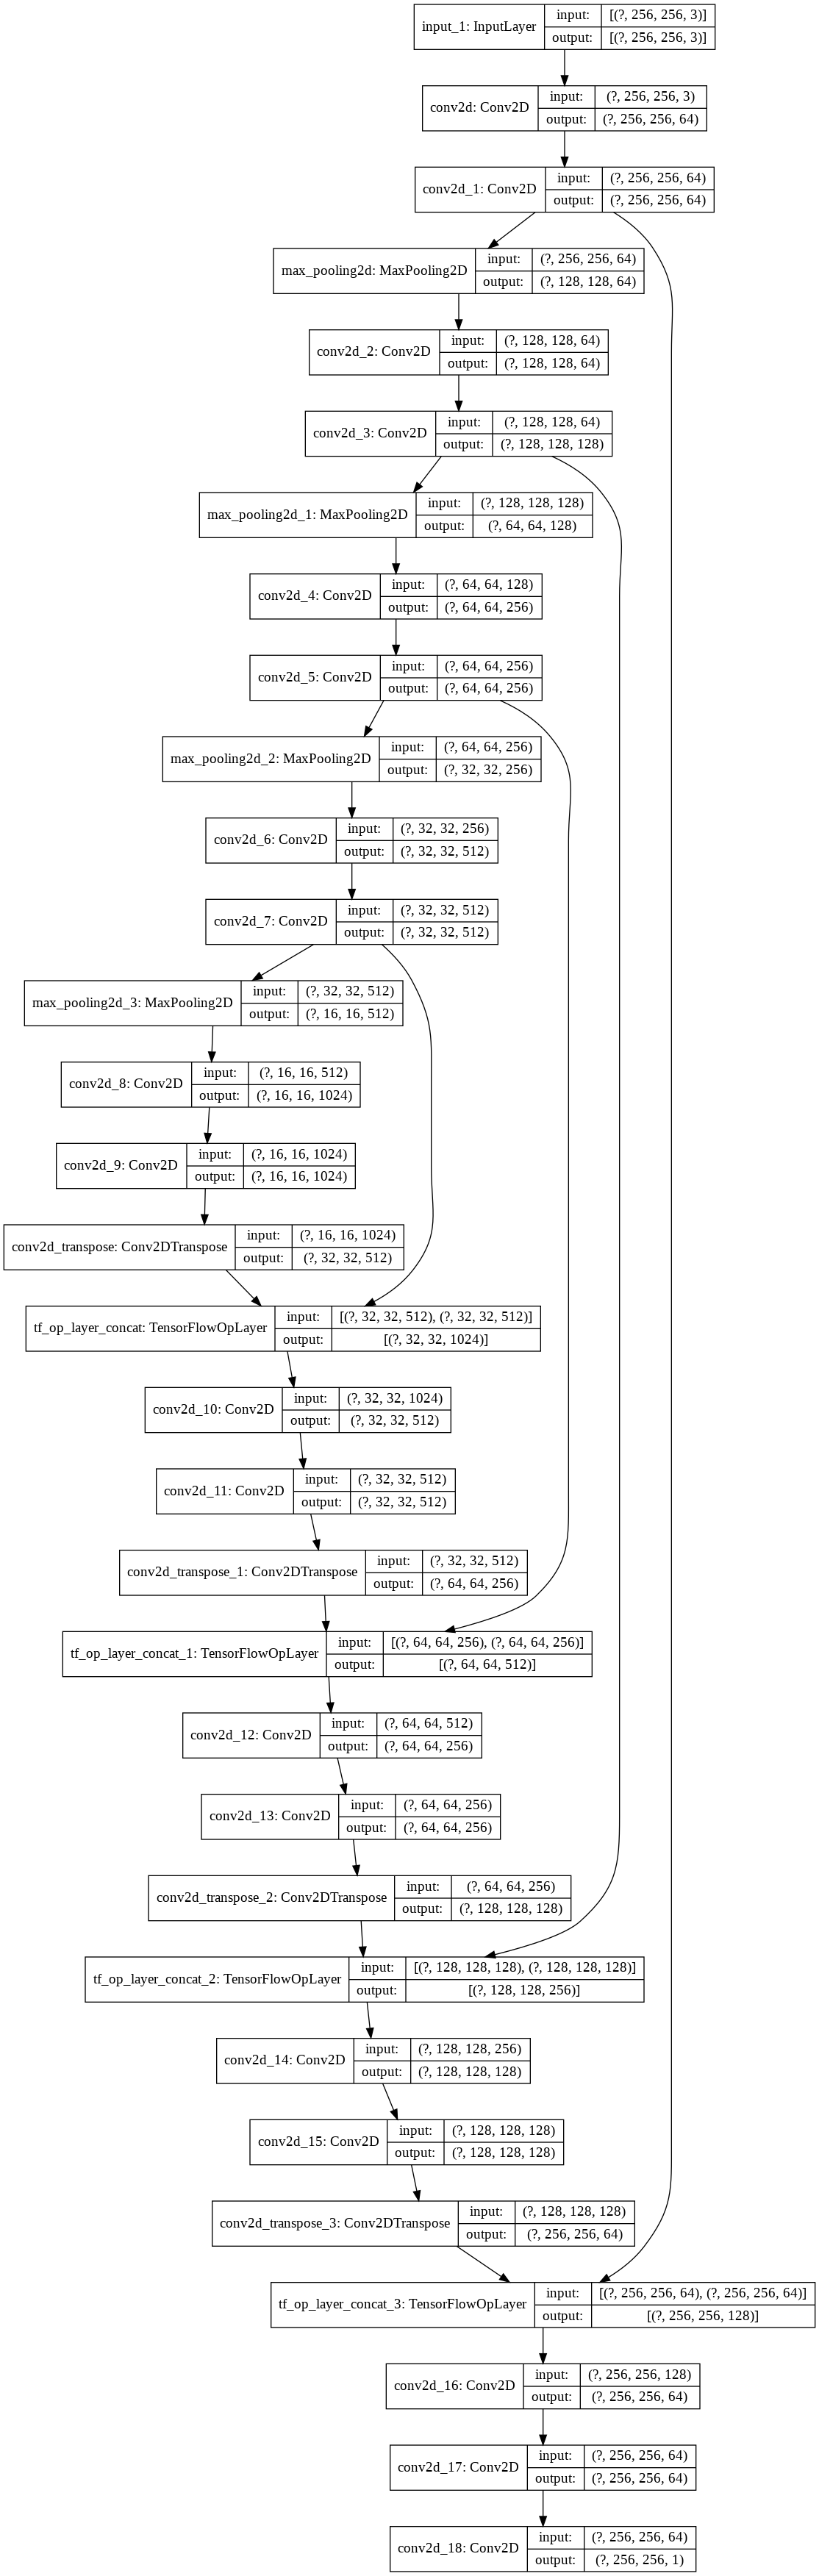

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
LEARNING_RATE = 0.0005

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy',
    metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs',
    write_graph=False,
    update_freq=100,
    profile_batch=0
)

In [21]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS
)

Epoch 1/5
781/781 [==============================] - 1589s 2s/step - loss: 0.4598 - accuracy: 0.7785
Epoch 2/5
781/781 [==============================] - 1571s 2s/step - loss: 0.3775 - accuracy: 0.8185
Epoch 3/5
781/781 [==============================] - 1577s 2s/step - loss: 0.3443 - accuracy: 0.8356
Epoch 4/5
781/781 [==============================] - 1570s 2s/step - loss: 0.3124 - accuracy: 0.8498
Epoch 5/5
781/781 [==============================] - 1573s 2s/step - loss: 0.2952 - accuracy: 0.8618
CPU times: user 1h 10min 6s, sys: 29min 26s, total: 1h 39min 32s
Wall time: 2h 14min 24s


In [22]:
model.evaluate(test_ds)

420/420 [==============================] - 403s 960ms/step - loss: 0.3013 - accuracy: 0.8532


[0.299363094329854, 0.8654412941932124]